# Morals of knowledge transfer

I present 3 techniques, accompanied by 3 moral analogies.

Disclaimer: the morals are totally unrelated from the phenomena. (This doesn't make them untrue tho.)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input, Softmax
from tensorflow.keras import Model

from plot import plot_predictions, plot_images, plot_image
from IPython.core.display import SVG

np.random.seed(420)
tf.random.set_seed(420)

# The dataset

## MNIST

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [3]:
def select_digits(digits=range(10)):
    x_train_selected = x_train[np.in1d(y_train, digits)]
    y_train_selected = y_train[np.in1d(y_train, digits)]
    return (x_train_selected, y_train_selected), (x_test, y_test)

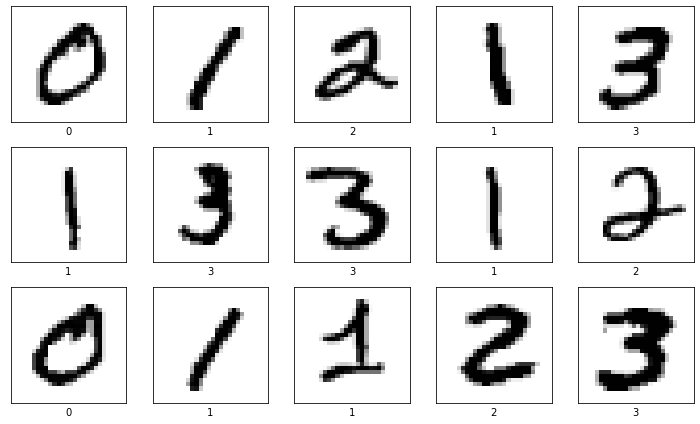

In [4]:
(x_train_selected, y_train_selected), (x_test, y_test) = select_digits([0, 1, 2, 3])

plot_images(x_train_selected, y_train_selected)

# The models

## Teacher

In [5]:
def teacher():
    return tf.keras.models.Sequential([
        Conv2D(32, 3, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10)
    ])

![](teacher.jpg)

## Student

In [6]:
def student():
    return tf.keras.models.Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(10)
    ])

![](student.jpg)

# Knowledge distillaton

## Train teacher

In [7]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

teacher_model = teacher()
teacher_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

teacher_model.fit(x_train_selected, 
          y_train_selected, 
          epochs=20, 
          validation_split=0.3, 
          callbacks=[tf.keras.callbacks.EarlyStopping()])

test_loss, test_acc = teacher_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', test_acc)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 13s 315us/sample - loss: 0.1925 - accuracy: 0.9407 - val_loss: 0.0763 - val_accuracy: 0.9772
Epoch 2/20
42000/42000 [==============================] - 13s 301us/sample - loss: 0.0621 - accuracy: 0.9805 - val_loss: 0.0735 - val_accuracy: 0.9787
Epoch 3/20
42000/42000 [==============================] - 13s 302us/sample - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0767 - val_accuracy: 0.9783
10000/10000 - 1s - loss: 0.0648 - accuracy: 0.9792

Test accuracy: 0.9792


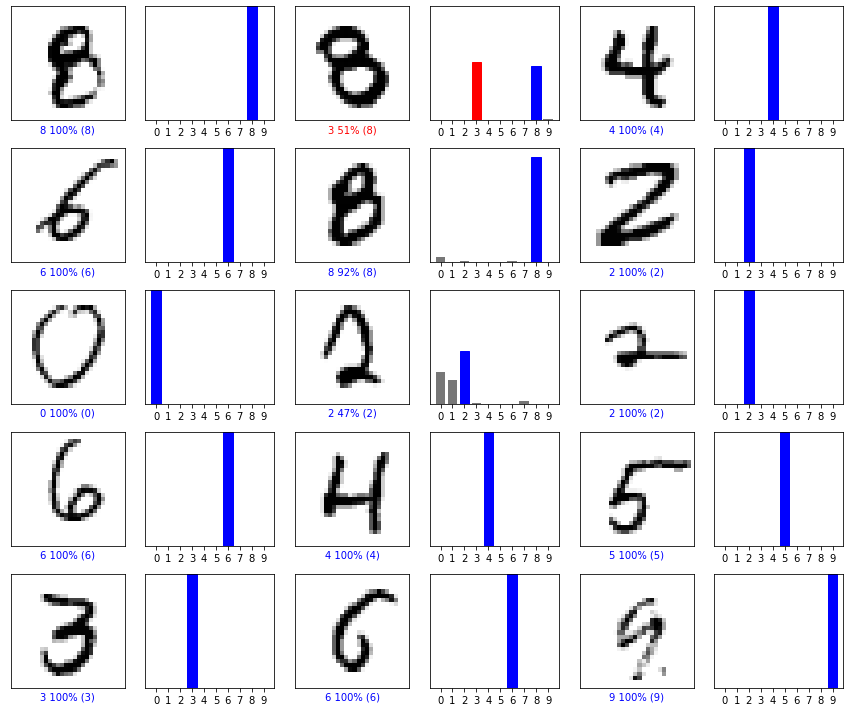

In [8]:
teacher_model_prob = tf.keras.Sequential([teacher_model, Softmax()])
predictions = teacher_model_prob.predict(x_test_selected)
plot_predictions(x_test_selected, y_test_selected, predictions)

## Train autodidact student

In [9]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

student_model = student()
student_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

student_model.fit(x_train_selected, 
                  y_train_selected, 
                  epochs=20, 
                  validation_split=0.3, 
                  callbacks=[tf.keras.callbacks.EarlyStopping()],
                 )

test_loss, auto_test_acc = student_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', auto_test_acc)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 2s 41us/sample - loss: 0.5315 - accuracy: 0.8631 - val_loss: 0.3395 - val_accuracy: 0.9079
Epoch 2/20
42000/42000 [==============================] - 2s 38us/sample - loss: 0.3207 - accuracy: 0.9109 - val_loss: 0.3047 - val_accuracy: 0.9149
Epoch 3/20
42000/42000 [==============================] - 1s 34us/sample - loss: 0.2942 - accuracy: 0.9171 - val_loss: 0.2961 - val_accuracy: 0.9188
Epoch 4/20
42000/42000 [==============================] - 1s 35us/sample - loss: 0.2808 - accuracy: 0.9208 - val_loss: 0.2864 - val_accuracy: 0.9216
Epoch 5/20
42000/42000 [==============================] - 1s 35us/sample - loss: 0.2720 - accuracy: 0.9231 - val_loss: 0.2863 - val_accuracy: 0.9221
Epoch 6/20
42000/42000 [==============================] - 1s 35us/sample - loss: 0.2662 - accuracy: 0.9253 - val_loss: 0.2875 - val_accuracy: 0.9202
10000/10000 - 0s - loss: 0.2741 - accuracy: 0.9235

Test

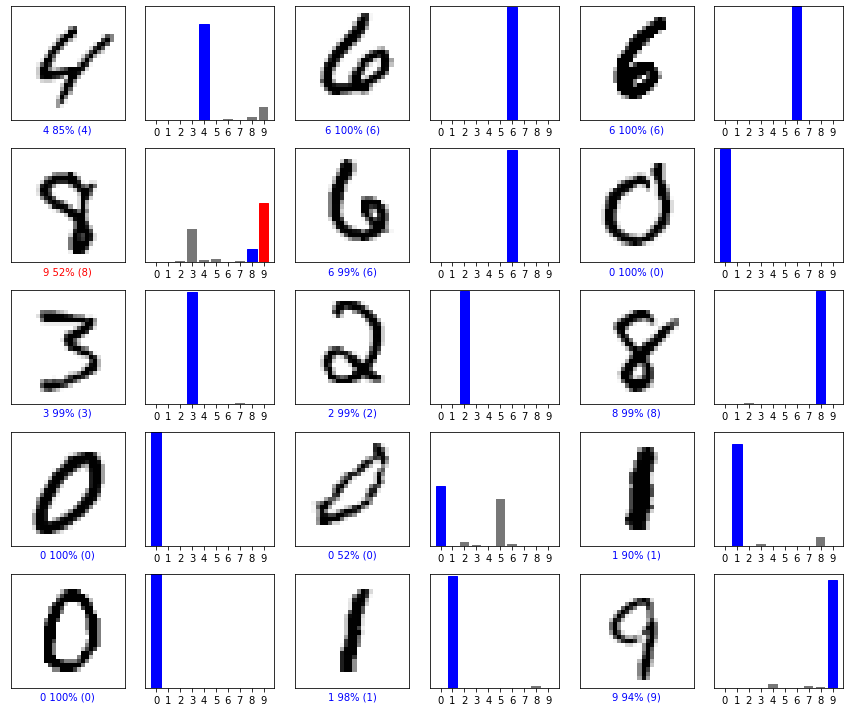

In [10]:
student_model_prob = tf.keras.Sequential([student_model, Softmax()])
predictions = student_model_prob.predict(x_test_selected)

plot_predictions(x_test_selected, y_test_selected, predictions)

## Episode: Softmax with temperature

\begin{equation*}
softmax(\mathbf{z})_c = \frac{e^{z_c}}{\sum_{d=1}^K e^{z_d}} \quad \text{for} \; c = 1 
\cdots K
\end{equation*}

\begin{equation*}
softmax(\mathbf{z}, T)_c = \frac{e^{\frac{z_c}{T}}}{\sum_{d=1}^K e^{\frac{z_d}{T}}} \quad \text{for} \; c = 1 \cdots K 
\end{equation*}

In [11]:
class TemperatureScale(tf.keras.layers.Layer):
    def __init__(self, t=1, **kwargs):
        super(TemperatureScale, self).__init__(**kwargs)
        self.t = t
    
    def call(self, inputs):
        return tf.divide(inputs, self.t)

In [12]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits()

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=1),
                                          Softmax()])
teacher_predictions_1 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=5),
                                          Softmax()])
teacher_predictions_5 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

teacher_model_prob = tf.keras.Sequential([teacher_model, 
                                          TemperatureScale(t=10),
                                          Softmax()])
teacher_predictions_10 = teacher_model_prob.predict(tf.expand_dims(x_train_selected[0], axis=0))

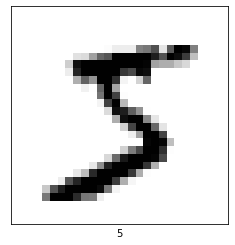

In [13]:
plot_image(x_train_selected[0], y_train_selected[0])
plt.show()

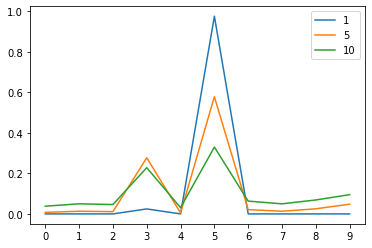

In [14]:
plt.plot(teacher_predictions_1[0])
plt.plot(teacher_predictions_5[0])
plt.plot(teacher_predictions_10[0])
plt.legend([1, 5, 10])
plt.xticks(range(10))
plt.show()

## Distill the dark knowledge

In [15]:
T = 2
teacher_model_prob = tf.keras.Sequential([teacher_model, TemperatureScale(t=T), Softmax()])
teacher_predictions = teacher_model_prob.predict(x_train_selected)

In [16]:
student_model = student()
student_model_T = tf.keras.Sequential([student_model, TemperatureScale(t=T)])
student_model_T.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                      metrics=['accuracy'])

student_model_T.fit(x_train_selected,
                  teacher_predictions, 
                  epochs=50, 
                  validation_split=0.3, 
                  callbacks=[tf.keras.callbacks.EarlyStopping()])

Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 2s 43us/sample - loss: 0.7520 - accuracy: 0.8470 - val_loss: 0.5011 - val_accuracy: 0.9026
Epoch 2/50
42000/42000 [==============================] - 2s 37us/sample - loss: 0.4852 - accuracy: 0.9021 - val_loss: 0.4544 - val_accuracy: 0.9143
Epoch 3/50
42000/42000 [==============================] - 2s 37us/sample - loss: 0.4545 - accuracy: 0.9105 - val_loss: 0.4406 - val_accuracy: 0.9174
Epoch 4/50
42000/42000 [==============================] - 2s 36us/sample - loss: 0.4410 - accuracy: 0.9146 - val_loss: 0.4322 - val_accuracy: 0.9200
Epoch 5/50
42000/42000 [==============================] - 2s 36us/sample - loss: 0.4330 - accuracy: 0.9168 - val_loss: 0.4284 - val_accuracy: 0.9212
Epoch 6/50
42000/42000 [==============================] - 1s 36us/sample - loss: 0.4278 - accuracy: 0.9188 - val_loss: 0.4274 - val_accuracy: 0.9213
Epoch 7/50
42000/42000 [==============================] 

In [17]:
metrics = student_model_T.evaluate(x_test_selected,  
                                 tf.one_hot(y_test_selected, depth=10),
                                 verbose=2)
test_loss, test_acc = metrics
print(f'\nTest accuracy: {test_acc:.4f} (vs {auto_test_acc:.4f})')

10000/10000 - 0s - loss: 0.2963 - accuracy: 0.9208

Test accuracy: 0.9208 (vs 0.9235)


In [18]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

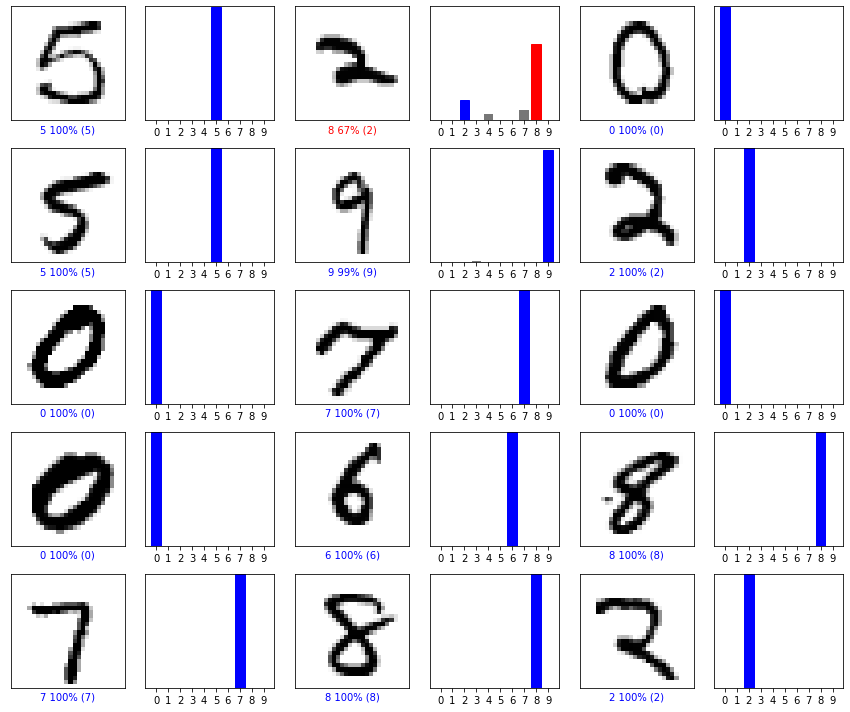

In [19]:
plot_predictions(x_test_selected, y_test_selected, predictions)

In [20]:
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.92      0.91      0.91      1032
           3       0.84      0.94      0.88      1010
           4       0.90      0.96      0.93       982
           5       0.93      0.85      0.89       892
           6       0.94      0.96      0.95       958
           7       0.94      0.91      0.92      1028
           8       0.91      0.87      0.89       974
           9       0.93      0.88      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Moral #1:

Those who can, do; those who can't, teach. But it's ok.

# Training on limited data

In [21]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits([0, 1, 2, 5])

student_model = student()
student_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

student_model.fit(x_train_selected, 
          y_train_selected, 
          epochs=20, 
          validation_split=0.3, 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

test_loss, auto_test_acc = student_model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print('\nTest accuracy:', auto_test_acc)

Train on 16830 samples, validate on 7214 samples
Epoch 1/20
16830/16830 [==============================] - 1s 48us/sample - loss: 0.3229 - accuracy: 0.9201 - val_loss: 0.1464 - val_accuracy: 0.9602
Epoch 2/20
16830/16830 [==============================] - 1s 35us/sample - loss: 0.1310 - accuracy: 0.9633 - val_loss: 0.1124 - val_accuracy: 0.9674
Epoch 3/20
16830/16830 [==============================] - 1s 36us/sample - loss: 0.1082 - accuracy: 0.9680 - val_loss: 0.1023 - val_accuracy: 0.9701
Epoch 4/20
16830/16830 [==============================] - 1s 35us/sample - loss: 0.0973 - accuracy: 0.9709 - val_loss: 0.0918 - val_accuracy: 0.9720
Epoch 5/20
16830/16830 [==============================] - 1s 35us/sample - loss: 0.0898 - accuracy: 0.9736 - val_loss: 0.0884 - val_accuracy: 0.9716
Epoch 6/20
16830/16830 [==============================] - 1s 35us/sample - loss: 0.0845 - accuracy: 0.9747 - val_loss: 0.0883 - val_accuracy: 0.9737
Epoch 7/20
16830/16830 [==============================] -

In [22]:
student_model_prob = tf.keras.Sequential([student_model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.68      0.99      0.81       980
           1       0.61      0.99      0.75      1135
           2       0.31      0.97      0.47      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.24      0.96      0.39       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.39     10000
   macro avg       0.18      0.39      0.24     10000
weighted avg       0.19      0.39      0.25     10000



/Users/metuoku/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


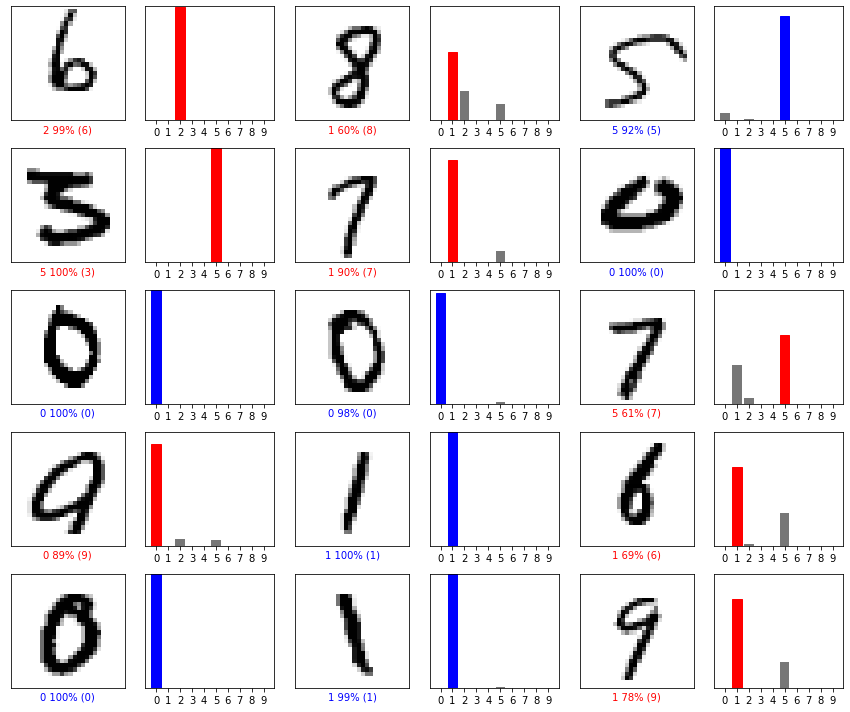

In [23]:
plot_predictions(x_test_selected, y_test_selected, predictions)

## Distillation on limited data

In [38]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits([0, 1, 2, 5])
T=2
teacher_model_prob = tf.keras.Sequential([teacher_model, TemperatureScale(t=T), Softmax()])
teacher_predictions = teacher_model_prob.predict(x_train_selected)

In [39]:
student_model = student()
student_model_T = tf.keras.Sequential([student_model, TemperatureScale(t=T)])
student_model_T.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

student_model_T.fit(x_train_selected, 
          teacher_predictions, 
          epochs=20, 
          validation_split=0.3, 
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                 verbose=0)

test_loss, test_acc = student_model_T.evaluate(x_test_selected,  
                                               tf.one_hot(y_test_selected, depth=10), 
                                               verbose=2)
print(f'\nTest accuracy: {test_acc:.4f} (vs {auto_test_acc:.4f})')

10000/10000 - 0s - loss: 1.6170 - accuracy: 0.4774

Test accuracy: 0.4774 (vs 0.8995)


In [43]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits([0, 1, 2, 5])
for T in [1, 2, 3, 4, 5, 10, 20, 50]:
    teacher_model_prob = tf.keras.Sequential([teacher_model, TemperatureScale(t=T), Softmax()])
    teacher_predictions = teacher_model_prob.predict(x_train_selected)

    student_model = student()
    student_model_T = tf.keras.Sequential([student_model, TemperatureScale(t=T)])
    student_model_T.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    student_model_T.fit(x_train_selected, 
              teacher_predictions, 
              epochs=20, 
              validation_split=0.3, 
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                     verbose=0)

    test_loss, test_acc = student_model_T.evaluate(x_test_selected,  
                                                   tf.one_hot(y_test_selected, depth=10), 
                                                   verbose=0)
    print(f'\n{T} Test accuracy: {test_acc:.4f} (vs {auto_test_acc:.4f})')


1 Test accuracy: 0.4383 (vs 0.8995)

2 Test accuracy: 0.4758 (vs 0.8995)

3 Test accuracy: 0.4766 (vs 0.8995)

4 Test accuracy: 0.4771 (vs 0.8995)

5 Test accuracy: 0.4827 (vs 0.8995)

10 Test accuracy: 0.4973 (vs 0.8995)

20 Test accuracy: 0.5027 (vs 0.8995)

50 Test accuracy: 0.5065 (vs 0.8995)


In [40]:
student_without_temp = Model(student_model.input, student_model.outputs[0])

student_model_prob = tf.keras.Sequential([student_without_temp, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)

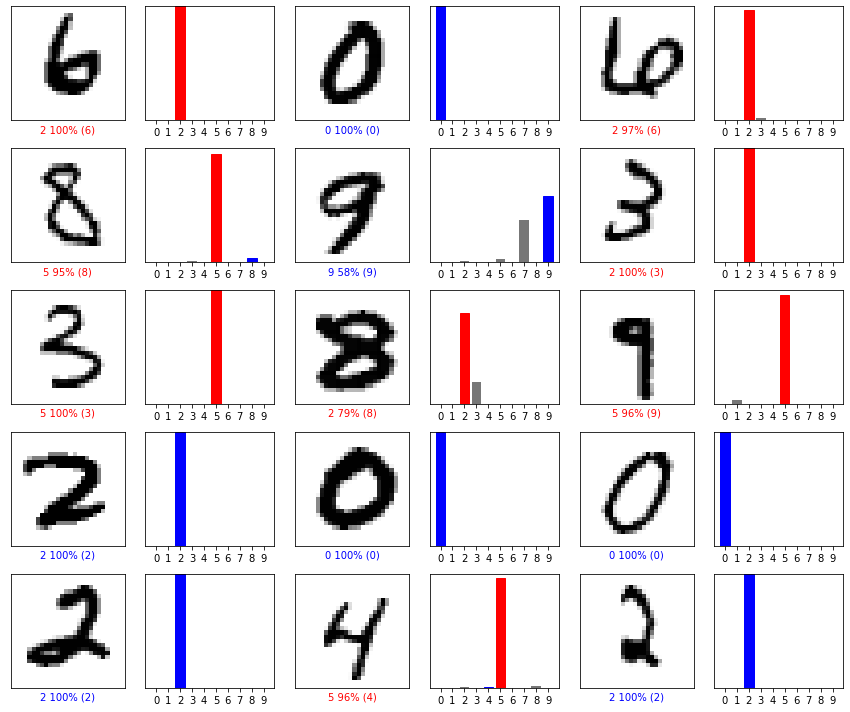

In [41]:
plot_predictions(x_test_selected, y_test_selected, predictions)

In [42]:
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       980
           1       0.69      0.99      0.82      1135
           2       0.35      0.97      0.51      1032
           3       0.48      0.22      0.30      1010
           4       0.83      0.08      0.15       982
           5       0.28      0.95      0.43       892
           6       0.91      0.09      0.17       958
           7       0.83      0.37      0.51      1028
           8       0.43      0.01      0.02       974
           9       0.54      0.05      0.10      1009

    accuracy                           0.48     10000
   macro avg       0.61      0.47      0.39     10000
weighted avg       0.62      0.48      0.40     10000



## Moral #2:

An experienced teacher might teach you more than the subject itself.

# Federated learning

In [31]:
def average_weights(models):
    w = models[0].get_weights()
    for i in range(1, len(models)):
        w_i = models[i].get_weights()
        for j in range(len(w)):
            w[j] += w_i[j]

    for j in range(len(w)):
        w[j] /= len(models)

    for m in models:
        m.set_weights(w)

In [32]:
models = []
for i in range(3):
    model = student()

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    models.append(model)

In [33]:
datasets = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8, 9],
]

In [34]:
rounds = 50
local_epochs = 1
for r in range(rounds):
    print(f'round {r}')
    for m, d in zip(models, datasets):
        (x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits(d)

        m.fit(x_train_selected, 
              y_train_selected, 
              epochs=local_epochs,
             verbose=0)
    test_loss, auto_test_acc = models[0].evaluate(x_test_selected,  y_test_selected, verbose=2)
    average_weights(models)
    test_loss, auto_test_acc = models[0].evaluate(x_test_selected,  y_test_selected, verbose=2)

round 0
10000/10000 - 0s - loss: 4.3151 - accuracy: 0.3077
10000/10000 - 0s - loss: 1.4515 - accuracy: 0.7499
round 1
10000/10000 - 0s - loss: 3.3758 - accuracy: 0.3085
10000/10000 - 0s - loss: 1.0782 - accuracy: 0.8028
round 2
10000/10000 - 0s - loss: 2.8419 - accuracy: 0.3096
10000/10000 - 0s - loss: 0.8877 - accuracy: 0.8228
round 3
10000/10000 - 0s - loss: 2.4779 - accuracy: 0.3295
10000/10000 - 0s - loss: 0.7762 - accuracy: 0.8333
round 4
10000/10000 - 0s - loss: 2.2190 - accuracy: 0.3610
10000/10000 - 0s - loss: 0.7033 - accuracy: 0.8421
round 5
10000/10000 - 0s - loss: 2.0267 - accuracy: 0.3920
10000/10000 - 0s - loss: 0.6516 - accuracy: 0.8481
round 6
10000/10000 - 0s - loss: 1.8779 - accuracy: 0.4223
10000/10000 - 0s - loss: 0.6129 - accuracy: 0.8522
round 7
10000/10000 - 0s - loss: 1.7589 - accuracy: 0.4489
10000/10000 - 0s - loss: 0.5827 - accuracy: 0.8572
round 8
10000/10000 - 0s - loss: 1.6613 - accuracy: 0.4667
10000/10000 - 0s - loss: 0.5583 - accuracy: 0.8620
round 9
10

In [35]:
i = 0
model = models[i]
dataset = datasets[i]

In [36]:
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits(dataset)
test_loss, auto_test_acc = model.evaluate(x_test_selected,  y_test_selected, verbose=2)
print(f'\nTest accuracy:', auto_test_acc)

10000/10000 - 0s - loss: 0.3640 - accuracy: 0.8995

Test accuracy: 0.8995


In [37]:
student_model_prob = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = student_model_prob.predict(x_test_selected)
(x_train_selected, y_train_selected), (x_test_selected, y_test_selected) = select_digits(dataset)
print(classification_report(y_test_selected, np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.94      0.98      0.96      1135
           2       0.91      0.84      0.87      1032
           3       0.87      0.91      0.89      1010
           4       0.88      0.92      0.90       982
           5       0.86      0.85      0.85       892
           6       0.91      0.93      0.92       958
           7       0.91      0.92      0.91      1028
           8       0.89      0.80      0.84       974
           9       0.89      0.86      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



### Moral #3:

Where we're going, we don't need teachers!